QUESTION 1

a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import linprog
from scipy.constants import mile
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2


import copy
import timeit

In [2]:
%reset -f

b)

i)

In [2]:
places = pd.read_csv('files-for-TMA04/places23.csv', index_col=0)
# We convert the table into cartesian coordinates using an ellipsoid model 
# of the earth. We convert the distances into miles and construct a table of distances between the places

def distance_deltas(latitude):
    # ellipsoid model WGS84
    a = 6378137.0
    b = 6356752.3142
    e = np.sqrt(1 - b ** 2 / a ** 2)

    phi = np.pi * latitude / 180
    c = a * np.pi / 180
    d = np.sqrt(1 - e ** 2 * np.sin(phi) ** 2)
    delta_long = c * np.cos(phi) / d
    delta_lat = c * (1 - e ** 2) / d ** 3
    return delta_long, delta_lat


theta = places['Longitude (° E)'].mean()
phi = places['Latitude (° N)'].mean()
delta_long, delta_lat = distance_deltas(phi)

places['x'] = delta_long * (places['Longitude (° E)'] - theta) / mile
places['y'] = delta_lat * (places['Latitude (° N)'] - phi) / mile

M = cdist(places[['x', 'y']], places[['x', 'y']], 'euclidean')
def to_one_dp(x):
    return round(x,1)
pd.DataFrame(M).apply(to_one_dp)


,0,1,2,3,4,5
0,0.0,87.8,17.4,73.8,44.4,183.2
1,87.8,0.0,71.3,140.9,87.2,259.7
2,17.4,71.3,0.0,87.3,38.3,199.6
3,73.8,140.9,87.3,0.0,117.2,119.0
4,44.4,87.2,38.3,117.2,0.0,219.5
5,183.2,259.7,199.6,119.0,219.5,0.0


ii)

Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimal tour has distance 447.0828212909507


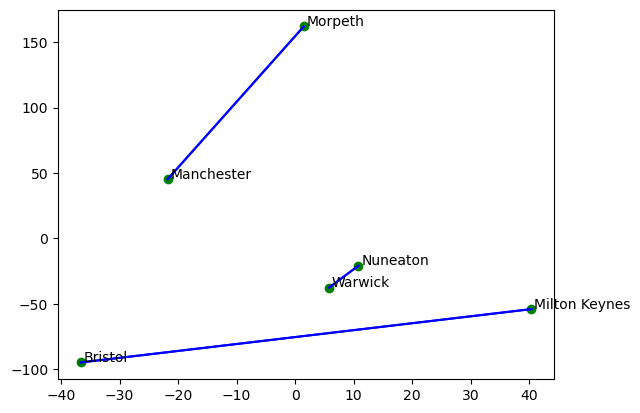

In [3]:
N = len(places)

# create columns with variable names
columns = []
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        columns.append(f'y{i}{j}')
        
columns.append('b')

df = pd.DataFrame(columns=columns)

# Add to the dataFrame the objective function and create the constraint to ensure that each place 
# has exactly one route beginning at it and one route ending at it
for i in range(N):
    for j in range(N):
        if i != j:
            df.loc['c', f'y{i}{j}'] = M[i, j]
            df.loc[f'start {i}', f'y{i}{j}'] = 1
            df.loc[f'end {i}', f'y{j}{i}'] = 1
    df.loc[f'start {i}', 'b'] = 1
    df.loc[f'end {i}', 'b'] = 1
    
df = df.fillna(0)

# we solve the model using the library function scipy.optimize.liprog and plot the results

A = df.drop(index='c').drop(columns='b')
b = df.drop(index='c')['b']
c = df.drop(columns='b').loc['c']

bds = [(0, 1)] * len(c)
variable_types = [1] * len(c)

result = linprog(c, A_eq=A, b_eq=b, bounds=bds,
                 integrality=variable_types)
print(result.message)
print(f'Optimal tour has distance {result.fun}')

# add result to data frame (add a zero for b column)
df.loc['result'] = np.append(result.x, 0)

# plot the results

plt.scatter(places['x'], places['y'], c='g')
for t in places.index:
    # add 0.5 to the x- and y-coordinates to move label away from marker
    plt.text(places.loc[t, 'x'] + 0.5, places.loc[t, 'y'] + 0.5, t)
    
for i in range(len(places)):
    for j in range(len(places)):
        # Use y_ij > 0.5 as a robust test for whether y_ij is 1
        if i != j and df.loc['result', f'y{i}{j}'] > 0.5:
            plt.plot(places.iloc[[i, j]]['x'], places.iloc[[i, j]]['y'], 'b')




Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimal tour has distance 458.22002063148915


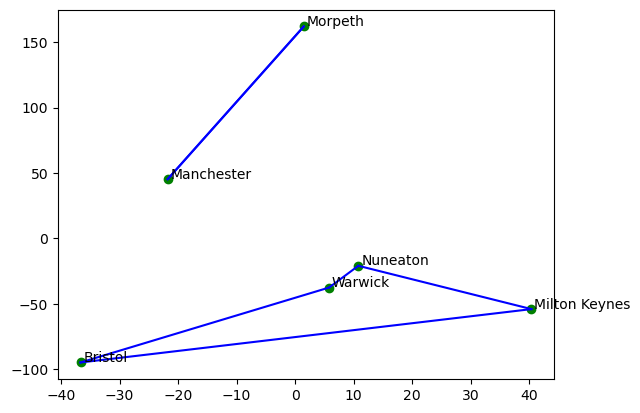

In [4]:
# The solution contains 3 disjoint subtours, so to avoid this we first create an additional constraint
# to ensure that the journey includes at least one route between any of these subtours

ub_df = pd.DataFrame(columns=columns)

NW = [0,2]
left_cities = [1,4,3,5]

for j in range(2):
    for k in range(4):
        ub_df.loc[f'ad hoc1', f'y{NW[j]}{left_cities[k]}'] =-1
        ub_df.loc[f'ad hoc1', f'b'] =-1
        
ub_df = ub_df.fillna(0)

A_ub = ub_df.drop(columns='b')
b_ub = ub_df['b']

result = linprog(c, A_eq=A, b_eq=b, A_ub=A_ub, b_ub=b_ub, bounds=bds,
integrality=variable_types)

print(result.message)
print(f'Optimal tour has distance {result.fun}')


# add result to data frame (add nan for b column)
df.loc['result'] = np.append([round(n) for n in result.x], np.nan)

#plot the new route


plt.scatter(places['x'], places['y'], c='g')
for t in places.index:
    plt.text(places.loc[t, 'x'] + 0.5, places.loc[t, 'y'] + 0.5, t)
for i in range(len(places)):
    for j in range(len(places)):
        if i != j and df.loc['result', f'y{i}{j}'] > 0.5:
            plt.plot(places.iloc[[i, j]]['x'], places.iloc[[i, j]]['y'], 'b')

Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimal tour has distance 572.7342275509682


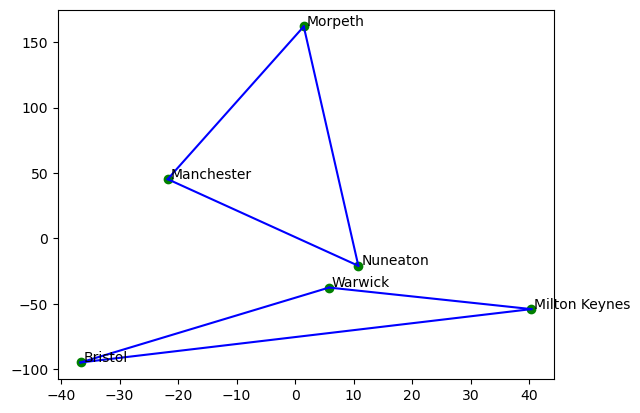

In [5]:
# Now the solution contains two subtours, so we create one more constraint

ManchMorp = [3,5]
NBWM = [0,1,2,4]

for j in range(2):
    for k in range(4):
        ub_df.loc[f'ad hoc2', f'y{ManchMorp[j]}{NBWM[k]}'] =-1
        ub_df.loc[f'ad hoc2', f'b'] =-1
            
ub_df = ub_df.fillna(0)

A_ub = ub_df.drop(columns='b')
b_ub = ub_df['b']

result = linprog(c, A_eq=A, b_eq=b, A_ub=A_ub, b_ub=b_ub, bounds=bds,
integrality=variable_types)

print(result.message)
print(f'Optimal tour has distance {result.fun}')


# add result to data frame (add nan for b column)
df.loc['result'] = np.append([round(n) for n in result.x], np.nan)

#plot the new route

plt.scatter(places['x'], places['y'], c='g')
for t in places.index:
    plt.text(places.loc[t, 'x'] + 0.5, places.loc[t, 'y'] + 0.5, t)
for i in range(len(places)):
    for j in range(len(places)):
        if i != j and df.loc['result', f'y{i}{j}'] > 0.5:
            plt.plot(places.iloc[[i, j]]['x'], places.iloc[[i, j]]['y'], 'b')
        

Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimal tour has distance 581.2089688096704


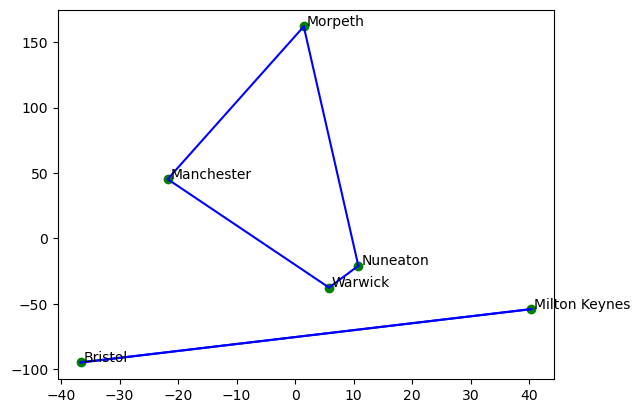

In [6]:
# We continue to add constraints

NMM = [0,3,5]
BWM = [1,2,4]

for j in range(3):
    for k in range(3):
        ub_df.loc[f'ad hoc3', f'y{NMM[j]}{BWM[k]}'] =-1
        ub_df.loc[f'ad hoc3', f'b'] =-1
            
ub_df = ub_df.fillna(0)

A_ub = ub_df.drop(columns='b')
b_ub = ub_df['b']

result = linprog(c, A_eq=A, b_eq=b, A_ub=A_ub, b_ub=b_ub, bounds=bds,
integrality=variable_types)

print(result.message)
print(f'Optimal tour has distance {result.fun}')


# add result to data frame (add nan for b column)
df.loc['result'] = np.append([round(n) for n in result.x], np.nan)


#plot the new route


plt.scatter(places['x'], places['y'], c='g')
for t in places.index:
    plt.text(places.loc[t, 'x'] + 0.5, places.loc[t, 'y'] + 0.5, t)
for i in range(len(places)):
    for j in range(len(places)):
        if i != j and df.loc['result', f'y{i}{j}'] > 0.5:
            plt.plot(places.iloc[[i, j]]['x'], places.iloc[[i, j]]['y'], 'b')


Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimal tour has distance 585.9296707136381


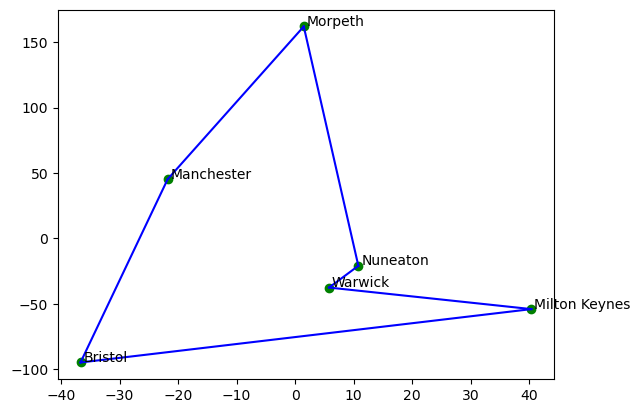

In [7]:
BM = [1,4]
NWMM = [0,2,3,5]

for j in range(2):
    for k in range(4):
        ub_df.loc[f'ad hoc4', f'y{BM[j]}{NWMM[k]}'] =-1
        ub_df.loc[f'ad hoc4', f'b'] =-1
            
ub_df = ub_df.fillna(0)


A_ub = ub_df.drop(columns='b')
b_ub = ub_df['b']

result = linprog(c, A_eq=A, b_eq=b, A_ub=A_ub, b_ub=b_ub, bounds=bds,
integrality=variable_types)

print(result.message)
print(f'Optimal tour has distance {result.fun}')


# add result to data frame (add nan for b column)
df.loc['result'] = np.append([round(n) for n in result.x], np.nan)

#plot the new route

plt.scatter(places['x'], places['y'], c='g')
for t in places.index:
    plt.text(places.loc[t, 'x'] + 0.5, places.loc[t, 'y'] + 0.5, t)
for i in range(len(places)):
    for j in range(len(places)):
        if i != j and df.loc['result', f'y{i}{j}'] > 0.5:
            plt.plot(places.iloc[[i, j]]['x'], places.iloc[[i, j]]['y'], 'b')

iii)

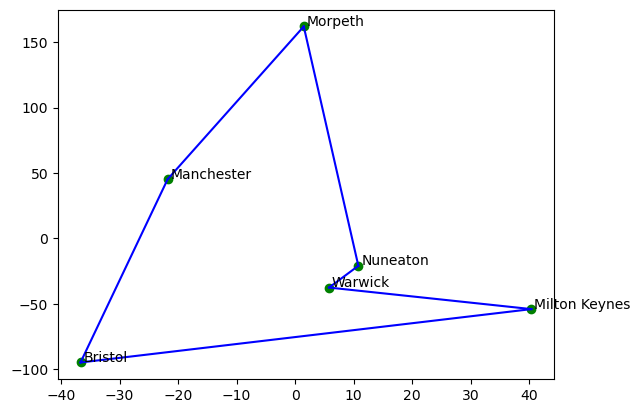

In [8]:
def find_route(df, N):
    """The function returns a list of lists that contains the routes between pairs of visited cities. 
    [[0,1],[2,4]...] for example. It requires a pandas DataFrame and the number of places as parameters """
    L = []
    for j in range(N):
        for k in range(N):
            if j != k and df.loc['result', f'y{j}{k}'] > 0.5:
                L.append([j,k])
               
            
    return L



L = find_route(df, N)
plt.scatter(places['x'], places['y'], c='g')
for t in places.index:
    plt.text(places.loc[t, 'x'] + 0.5, places.loc[t, 'y'] + 0.5, t)
for i in L:
    plt.plot(places.iloc[[i[0], i[1]]]['x'], places.iloc[[i[0], i[1]]]['y'], 'b')

c)

i)

In [9]:
def create_places(N):
    """It returns an array M of coordinates x,y in the form [[x, y],...]"""
    M = np.array(np.random.uniform(-100.0, 100.0, (N,2)))
    return M

B = create_places(13)

ii)

In [64]:
%reset -f

The shortest distance is 777.7989717642736
Number of constraints -  3


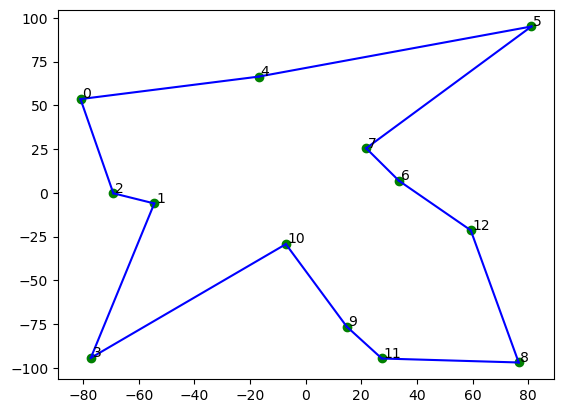

In [10]:
def create_sets(v_cities):
    """A function to help us see if any subtours have been created.
    Returns a list of lists called sets where sets[0] is the route as integers without duplicates
    that starts and ends with place 0. if this is not the whole route, we add sets[1], 
    which holds the remaining cities."""

    v_cities_copy = copy.deepcopy(v_cities)
    start = v_cities_copy.pop(0)
    
    sets = [start]
    counter = 0
    
    """Here we check if any of the cities in sets, starting with the first 2, has been entered or exited from
    any of the other cities. If so, we add the city to sets, delete the entry in v_cities, 
    restart the counter and check again with the updated set"""
    while counter <= len(v_cities_copy)-1:
        current = v_cities_copy[counter]
        if current[0] in sets[0] and current[1] not in sets[0]:
            sets[0].append(current[1])
            v_cities_copy.remove(current)
            counter = 0
            continue
        elif current[1] in sets[0] and current[0] not in sets[0]:
            sets[0].append(current[0])
            v_cities_copy.remove(current)
            counter = 0
            continue
        counter += 1


    # Add the set with the remaiinig cities - those which were not part of the subroute above
    left_cities = []
    for k in range(len(v_cities)):
        if k not in sets[0]:
            left_cities.append(k)
    if len(left_cities) > 0: 
        sets.append(left_cities)
        
    return sets
            

def find_route(df, N):
    """The function returns a list of lists that contains the routes between pairs of visited cities. 
    [[0,1],[2,4]...] for example """
    L = []
    for j in range(N):
        for k in range(N):
            # we add a coma between j and k to accomodate for N larger than 9
            if j != k and df.loc['result', f'y{j},{k}'] > 0.5:
                L.append([j,k])
               
            
    return L


def add_constraint(sets, adhoc,dataFrame):
    constraint = []
    # for each set in sets
    for i in range(len(sets)):
        # for each city in the current set
        for j in sets[i]:
            # for each city in the remaining sets
            for k in range(i+1, len(sets)):
                # make sure there is at least one route from any of the cities from the current set 
                # to any of the cities from the remaining sets
                for y in sets[k]:
                    dataFrame.loc[f'ad hoc{adhoc}', f'y{j},{y}'] =-1
                    dataFrame.loc[f'ad hoc{adhoc}', f'b'] =-1
                    
    return dataFrame.fillna(0)
    

def travelling_salesperson(M):

    Distances = cdist(M,M, "euclidean")
    
    N = len(M)
    
# create columns with variable names
    columns = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            columns.append(f'y{i},{j}')

    columns.append('b')

    df = pd.DataFrame(columns=columns)

    # Add to the dataFrame the objective function and create the constraint to ensure that each place 
    # has exactly one route beginning at it and one route ending at it
    for i in range(N):
        for j in range(N):
            if i != j:
                df.loc['c', f'y{i},{j}'] = Distances[i, j]
                df.loc[f'start {i}', f'y{i},{j}'] = 1
                df.loc[f'end {i}', f'y{j},{i}'] = 1
        df.loc[f'start {i}', 'b'] = 1
        df.loc[f'end {i}', 'b'] = 1

    df = df.fillna(0)
    

    # we solve the model using the library function scipy.optimize.liprog and plot the results

    A = df.drop(index='c').drop(columns='b')
    b = df.drop(index='c')['b']
    c = df.drop(columns='b').loc['c']

    bds = [(0, 1)] * len(c)
    variable_types = [1] * len(c)

    result = linprog(c, A_eq=A, b_eq=b, bounds=bds,
                     integrality=variable_types)
    result_x_append_for_b = np.append(result.x,0)
    df.loc["result"] = np.append([round(n) for n in result.x], np.nan)
    visited_cities = find_route(df, N)

    
    
    # if there are any subtours, they will be in sets
    sets = create_sets(visited_cities)
    
    # when we have more than 1 tour, we start adding constraints
    if len(sets) > 1:
        adhoc = 1
        ub_df = pd.DataFrame(columns = columns)
        ub_df.fillna(0)
        while len(sets) > 1:
            constraint = add_constraint(sets,adhoc,ub_df)
            A_ub = constraint.drop(columns='b')
            b_ub = constraint['b']
            result = linprog(c, A_eq=A, b_eq=b, A_ub=A_ub, b_ub=b_ub, bounds=bds,
            integrality=variable_types)
            result_x_append_for_b = np.append(result.x,0)
            df.loc["result"] = np.append([round(n) for n in result.x], np.nan)
            
            visited_cities = find_route(df, N)
            sets = create_sets(visited_cities)
            adhoc +=1 
    
    
  
    print("The shortest distance is", result.fun)
    print("Number of constraints - ", adhoc)
    
    
    plt.scatter(M[:,0], M[:,1], c='g')
    for i in visited_cities:
        plt.text(M[int(i[-1]),0] + 0.6, M[int(i[-1]),1] + 0.6, i[-1])
    for i in range(len(visited_cities)):
        for j in range(len(visited_cities)):
            if i != j and df.loc['result', f'y{i},{j}'] > 0.5:
                plt.plot([M[i,0], M[j,0]], [M[i,1], M[j,1]], 'b')
    
    
    
   
        
travelling_salesperson(B)




iii)

In [31]:

columns = np.arange(2,17)
data = pd.DataFrame(index = range(1,11),columns = columns)
data = data.fillna(0)

def time_my_function(data, function):
    for j in range(2,17):
        for k in range(10):
            coordinates = create_places(j)
            timing = %timeit -o -q  -r1   -n5   function(coordinates)
            data.iloc[k,j-2] = timing.average
            
    return data


data = time_my_function(data, travelling_salesperson)

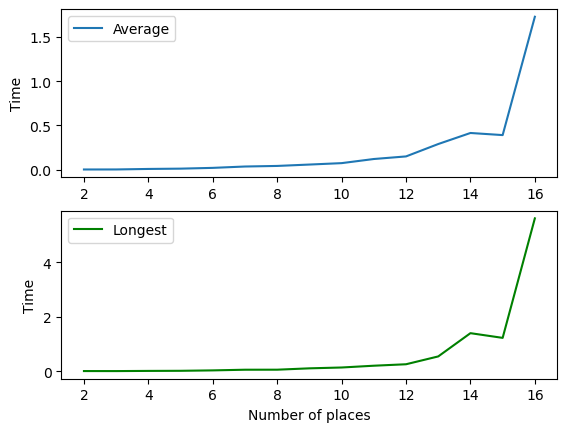

In [20]:


average = []
longest = []
for j in range(2,17):
    average.append(data[j].agg('mean'))
    longest.append(max(data[j]))
    
    
fig, (ax1, ax2) = plt.subplots(2)
    
ax1.plot(columns,average,label = 'Average')
ax1.set(ylabel = 'Time')
ax1.legend(loc='upper left')



ax2.plot(columns,longest, 'g',label = 'Longest')
plt.xlabel('Number of places')
plt.ylabel('Time')
plt.legend();


d)

In [22]:


def travelling_salesperson_general(M):
    
    Distances = cdist(B,B, "euclidean")
    N = len(M)

    # create columns with variable names
    columns = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            columns.append(f'y{i},{j}')
    for i in range(N):
        columns.append(f'u{i}')

    columns.append('b')

    df = pd.DataFrame(columns=columns)

    for i in range(N):
        for j in range(N):
            if i != j:
                df.loc['c', f'y{i},{j}'] = Distances[i, j]
                df.loc[f'start {i}', f'y{i},{j}'] = 1
                df.loc[f'end {i}', f'y{j},{i}'] = 1
        df.loc[f'start {i}', 'b'] = 1
        df.loc[f'end {i}', 'b'] = 1
    df.loc['u0=0', 'u0'] = 1
    df.loc['u0=0', 'b'] = 0

    df = df.fillna(0)

    A = df.drop(index='c').drop(columns='b')
    b = df.drop(index='c')['b']
    c = df.drop(columns='b').loc['c']

    ub_df = pd.DataFrame(columns=columns)

    for i in range(N):
        for j in range(1, N):
            if i != j:
                ub_df.loc[f'tour {i},{j}', f'u{j}'] = -1
                ub_df.loc[f'tour {i},{j}', f'u{i}'] = 1
                ub_df.loc[f'tour {i},{j}', f'y{i},{j}'] = len(M)
                ub_df.loc[f'tour {i},{j}', f'b'] = len(M)-1

    ub_df = ub_df.fillna(0)

    A_ub = ub_df.drop(columns='b')
    b_ub = ub_df['b']

    # the y_{ij} are 0-1 variables, and the u_i are not bounded above
    bds = [(0, 1)] * (len(c) - N) + [(0, None)] * N
    # all variables are integer
    variable_types = [1] * len(c)
    result = linprog(c, A_eq=A, b_eq=b, A_ub=A_ub, b_ub=b_ub, bounds=bds,
                     integrality=variable_types)
    #print(result.message)
    #print(f'Optimal tour has distance {result.fun}')

    # add result to data frame (add a zero for b column)
    df.loc['result'] = np.append(result.x, 0)

    df.loc['result'].apply(round)
    
    """
    plt.scatter(M[:,0], M[:,1], c='g')
    for i in range(len(M)):
        plt.text(M[i,0] + 0.6, M[i,1] + 0.6, i)
    for i in range(len(M)):
        for j in range(len(M)):
            if i != j and df.loc['result', f'y{i},{j}'] > 0.5:
                plt.plot([M[i,0], M[j,0]], [M[i,1], M[j,1]], 'b')"""
    
    
    
    
print(travelling_salesperson_general(B))

In [32]:
data2 = pd.DataFrame(index = range(1,11),columns = columns)
data2 = data2.fillna(0)


data2 = time_my_function(data2, travelling_salesperson_general)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Running times for travelling_salesman for number of places N from 2 to 16


,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,0.006157,0.004744,0.008954,0.015133,0.024733,0.039681,0.095536,0.064335,0.065139,0.096561,0.440982,0.162186,0.384578,1.969693,3.677656
2,0.003627,0.004525,0.009674,0.012588,0.022738,0.020327,0.039411,0.068762,0.073127,0.106201,0.069684,0.305928,0.158075,0.585787,0.506813
3,0.003749,0.004634,0.009637,0.012112,0.019798,0.023947,0.047216,0.078275,0.106127,0.091538,0.146498,0.378830,0.838601,0.205127,0.552213
4,0.003182,0.005889,0.010851,0.015344,0.019489,0.039427,0.055842,0.038315,0.142986,0.070899,0.156801,0.198617,0.312736,0.211780,1.080277
5,0.003145,0.005071,0.009790,0.015649,0.021729,0.037217,0.033349,0.070151,0.112128,0.074319,0.274495,0.401461,0.309233,0.212769,1.404649
6,0.003178,0.004755,0.009669,0.015134,0.019525,0.026959,0.051676,0.049944,0.139908,0.074764,0.118278,0.349307,0.378030,0.481530,1.923448
7,0.003296,0.004834,0.009197,0.014537,0.023468,0.021485,0.054670,0.040099,0.097925,0.145240,0.130300,0.237928,0.324007,0.311900,1.122554
8,0.003432,0.004318,0.009280,0.011674,0.031089,0.022805,0.042952,0.066791,0.084240,0.184091,0.080711,0.169607,0.333767,0.383201,0.456944
9,0.003287,0.004605,0.009456,0.015056,0.025519,0.037990,0.042249,0.098457,0.106534,0.131536,0.353197,0.136338,0.153947,1.049248,1.235257
10,0.003304,0.003953,0.009101,0.017008,0.019745,0.047046,0.035928,0.065139,0.133732,0.119826,0.165412,0.129676,0.318450,0.386367,3.106845


Running times for travelling_salesman general for number of places N from 2 to 16


,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,0.009638,0.008891,0.011679,0.023373,0.031864,0.054744,0.220296,0.388341,0.641390,1.936056,1.456131,4.503478,6.578931,3.704169,7.457782
2,0.006189,0.008493,0.011421,0.023439,0.033690,0.053677,0.220548,0.398733,0.660719,2.085327,1.305737,4.498800,6.472756,3.627215,7.582412
3,0.005999,0.007652,0.010939,0.023122,0.029294,0.059636,0.226503,0.384028,0.678926,2.220421,1.576361,5.000769,6.981386,3.699433,7.406254
4,0.006019,0.007745,0.011188,0.023331,0.029699,0.058914,0.226594,0.380794,0.705087,2.104707,1.271716,5.065669,6.411885,3.667033,7.451053
5,0.006146,0.007754,0.010869,0.024582,0.029025,0.060876,0.221154,0.370112,0.641272,2.090092,1.407764,5.419306,6.086995,3.746405,7.611507
6,0.005753,0.007773,0.011235,0.027218,0.030811,0.063269,0.212165,0.368815,0.624116,2.153685,1.306930,5.880418,5.985958,3.752297,7.407788
7,0.005182,0.007697,0.010832,0.026518,0.034432,0.060175,0.233585,0.390273,0.636891,2.006147,1.300596,5.773826,5.919976,3.712740,7.490879
8,0.004903,0.007240,0.011298,0.025381,0.035027,0.057741,0.222344,0.383254,0.693189,2.028832,1.349495,5.392263,5.840981,3.672798,7.659847
9,0.005522,0.007341,0.010811,0.025052,0.033370,0.075531,0.225299,0.377344,0.664341,2.189650,1.257041,5.291151,5.912455,3.630334,7.426765
10,0.006221,0.007461,0.011614,0.025088,0.028544,0.064963,0.231136,0.376411,0.652288,2.123983,1.380442,5.716348,5.961203,3.649867,7.432482


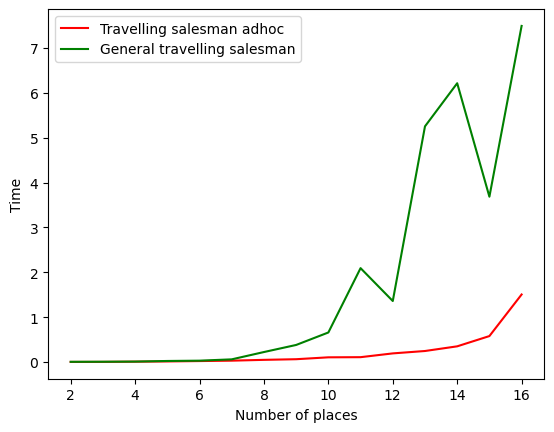

In [40]:

trav_salesman_time = []
trav_salesman_gen_time = []
for j in range(2,17):
    trav_salesman_time.append(data[j].agg('mean'))
    trav_salesman_gen_time.append(data2[j].agg('mean'))
    
print("Running times for travelling_salesman for number of places N from 2 to 16")
display(data)

print("Running times for travelling_salesman general for number of places N from 2 to 16")
display(data2)
    
plt.plot(columns, trav_salesman_time, "r", label = 'Travelling salesman adhoc')
plt.plot(columns, trav_salesman_gen_time, "g", label = 'General travelling salesman')
plt.xlabel('Number of places')
plt.ylabel('Time')
plt.legend();

In [95]:
N =17
coordinates = create_places(N)

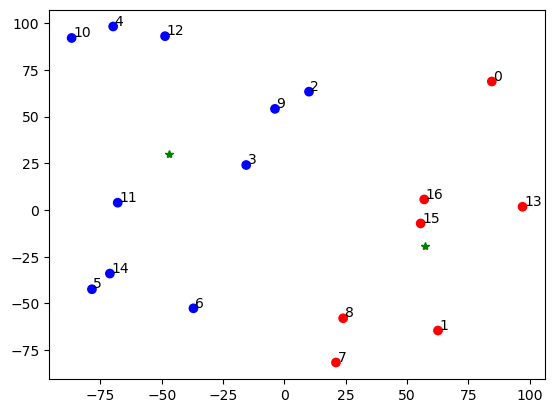

In [96]:
dist = cdist(coordinates, coordinates, 'euclidean')
centres, labels = kmeans2(coordinates[:, :2], 2)
label_colours = np.array(['r', 'b'])[labels]
for j in range(len(coordinates)):
    plt.text(coordinates[j][0] + 0.6, coordinates[j][1] + 0.6, j)
plt.scatter(coordinates[:, 0], coordinates[:, 1], color=label_colours)
plt.plot([centres[0][0], centres[1][0]], [centres[0][1], centres[1][1]], 'g*')


Travelling salesperson time for N = 17:

The shortest distance is 729.2355563654622
Number of constraints -  16
CPU times: total: 922 ms
Wall time: 1.66 s


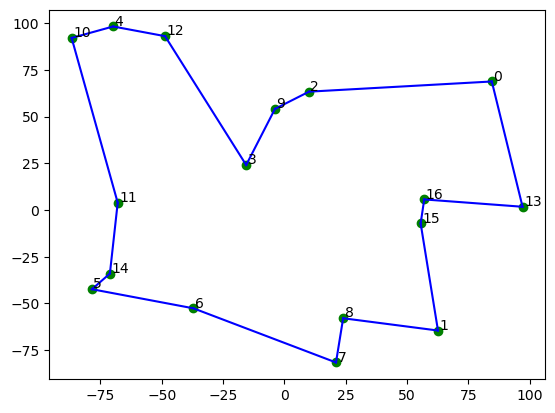

In [97]:
print('Travelling salesperson time for N = ' + f'{N}' + ':')
print()
%time travelling_salesperson(coordinates)

In [98]:
coordinates[[0,15]] = coordinates[[15,0]]

Travelling salesperson with order changed for N = 17:

The shortest distance is 729.235556365462
Number of constraints -  11
CPU times: total: 781 ms
Wall time: 1.21 s


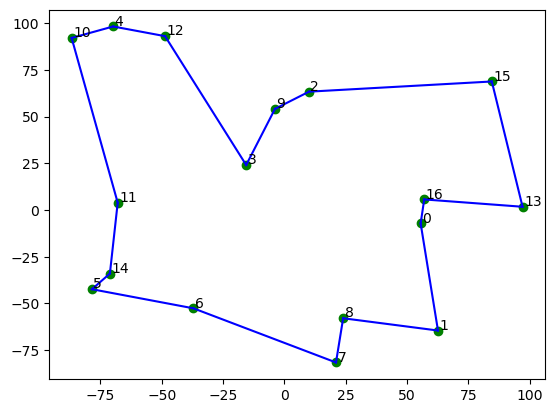

In [99]:

print("Travelling salesperson with order changed for N = " + f'{N}' + ":")
print()
%time travelling_salesperson(coordinates)